In [1]:
import torch
import numpy as np

In [2]:
from torch import nn, optim as opts
from plasma.training import Trainer, metrics, callbacks, data
from plasma.modules import *
from tensorflow.keras.datasets import mnist

In [3]:
(x, y), _ = mnist.load_data()

x = x[y < 3] / 127.5 - 1
y = y[y < 3]

class Data(data.StandardDataset):
    
    def get_len(self):
        return x.shape[0]
    
    def get_item(self, idx):
        return x[idx, None], y[idx]

In [4]:
g_model = nn.Sequential(*[
    PrimaryGroupConv2d(1, 16, kernel_size=3),
    GroupBatchNorm2d(16),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    GroupConv2d(16, 32, kernel_size=3),
    GroupBatchNorm2d(32),
    nn.ReLU(inplace=True),
    nn.MaxPool2d(2, 2),
    GroupGlobalAverage(),
    nn.Linear(32, 3)
])

g_model.cuda(0)

Sequential(
  (0): PrimaryGroupConv2d(in_channels=1, out_channels=16, kernel=3, stride=1, padding=1, bias=True)
  (1): GroupBatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): GroupConv2d(in_channels=16, out_channels=32, kernel=3, stride=1, padding=1, dilation=1, groups=1, bias=True)
  (5): GroupBatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU(inplace=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): GroupGlobalAverage()
  (9): Linear(in_features=32, out_features=3, bias=True)
)

In [5]:
loss = nn.CrossEntropyLoss()

In [6]:
#opt = opts.RMSprop(model.parameters())
opt = opts.SGD(g_model.parameters(), lr=0.25, momentum=0.9, nesterov=True)
trainer = Trainer(g_model, opt, loss, metrics=[metrics.accuracy], x_device="cuda:0", y_device="cuda:0")

In [7]:
cbs = [
    #callbacks.LrFinder(min_lr=1e-5, max_lr=2, epochs=3)
    callbacks.WarmRestart(1e-5, 10, factor=2, cycles=3, snapshot=False),
    #callbacks.CLR(1e-5, 4),
    #callbacks.TrainingScheduler(epochs=1)
    callbacks.CSVLogger("train.csv")
]

In [8]:
trainer.fit(Data(), callbacks=cbs, batch_size=64)

epoch 1



epoch 2



epoch 3



epoch 4



epoch 5



epoch 6


KeyboardInterrupt: 

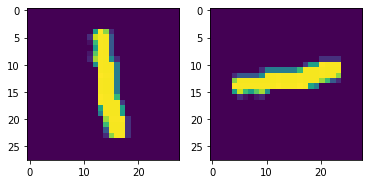

((1, 28, 28), 1.0, -1.0)

In [9]:
import matplotlib.pyplot as plt
import numpy as np

a = Data()[3][0]
ar = np.rot90(a, axes=[1, 2])
ar = np.copy(ar)

_, ax = plt.subplots(ncols=2)
ax[0].imshow(a[0])
ax[1].imshow(ar[0])
plt.show()
a.shape, a.max(), a.min()

In [10]:
img = torch.tensor(a[None], dtype=torch.float, device="cuda:0")
g_model.eval()(img)

tensor([[-5.4410,  6.0561, -1.3378]], device='cuda:0', grad_fn=<AddmmBackward>)

In [11]:
img = torch.tensor(ar[None], dtype=torch.float, device="cuda:0")
g_model.eval()(img)

tensor([[-6.6985,  3.5518,  2.5033]], device='cuda:0', grad_fn=<AddmmBackward>)

In [12]:
from albumentations import Rotate

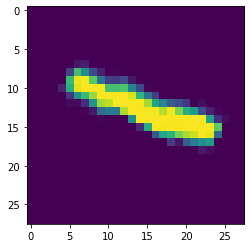

In [13]:
ar30 = Rotate(limit=(-30, -30), always_apply=True, border_mode=1)(image=ar[0])["image"]
plt.imshow(ar30)
plt.show()

In [14]:
img = torch.tensor(ar30[None, None], dtype=torch.float, device="cuda:0")
g_model.eval()(img)

tensor([[-3.4659,  0.3162,  2.6750]], device='cuda:0', grad_fn=<AddmmBackward>)